In [ ]:
## IMPORTS
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric

!pip freeze > requirements.txt
!pip list --format=freeze > requirements.txt

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 61.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 21.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.3 MB/s eta 0:00:00


In [440]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

dataset = Planetoid(root='./data', name='Cora')
data = dataset[0]

In [441]:
!pip install wandb
import wandb
wandb.login()

True

In [442]:
## PARAMETERS
embedding_dim = 128
walk_length=50
context_size=16
walks_per_node=4
num_negative_samples=2
p=0.5  # Defines (unormalised) probability, 1/p, of returning to source node
q=5  # Defines (unormalised) probability, 1/q, for moving away from source node

lr=0.01
epochs=50
batch_size=64

In [443]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the Node2Vec model
model = Node2Vec(data.edge_index, embedding_dim, walk_length=walk_length, context_size=context_size,
                 walks_per_node=walks_per_node, num_negative_samples=num_negative_samples, p=p, q=q, sparse=True).to(device)

# Initialize the SGD optimizer with momentum
loader = model.loader(batch_size=batch_size, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=lr)

print(model)

Node2Vec(2708, 128)


In [444]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask], z[data.test_mask], data.y[data.test_mask], max_iter=150)
    return acc

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.title(f'embs_p {p}_q {q}_size {embedding_dim}')
    plt.savefig(f'embs_p {p}_q {q}_size {embedding_dim}.jpg')
    plt.show()

In [445]:
wandb.init(project="project_lab2_node2vec")
for epoch in tqdm(range(epochs)):
    loss = train()
    acc = test()
    wandb.log({"Loss": loss, "Acc": acc, "Epoch": epoch + 1})
wandb.finish()

100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


Acc,▁▂▂▃▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇█████████████████████
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.677
Epoch,50
Loss,0.77856


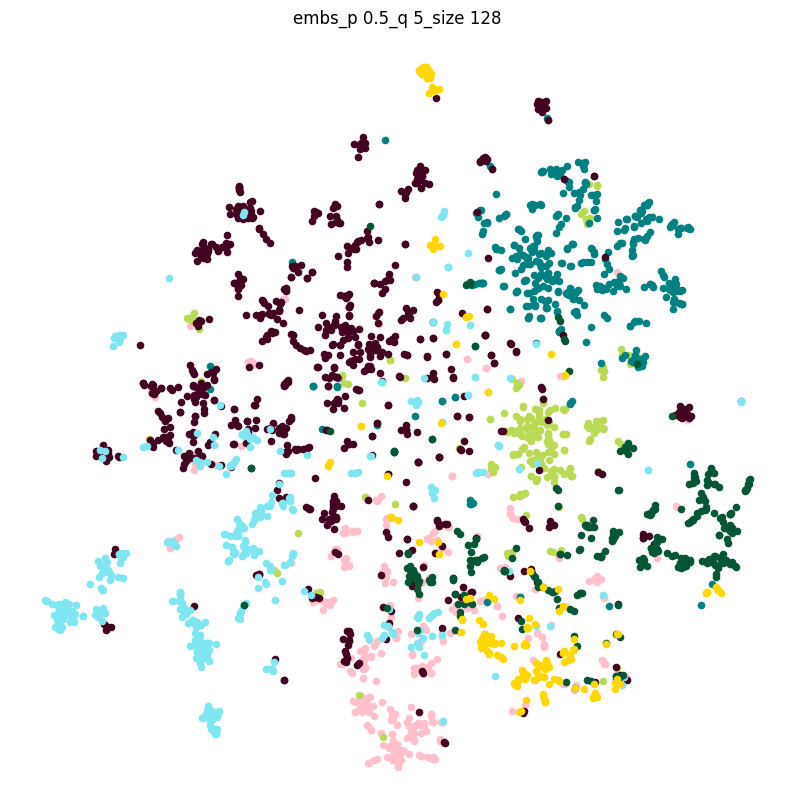

In [446]:
colors = [ '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700' ]
plot_points(colors)

In [447]:
import numpy as np
import torch
from torch_geometric.datasets import Planetoid
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Node2Vec modell beágyazások betöltése
embeddings = model()
embeddings = embeddings.cpu().detach().numpy()
# Az éleket tartalmazó gráf előkészítése
edge_index = data.edge_index

# Gráf mérete
num_nodes = data.num_nodes

# Beágyazások közötti hasonlóság kiszámítása (példában koszinusz hasonlóság)
similarity_matrix = np.dot(embeddings, embeddings.T)

matrix_size = num_nodes
matrix = np.zeros((matrix_size, matrix_size))
for i,j in edge_index.T:
  matrix[i,j] = 1

predictions = similarity_matrix.flatten()
#predictions = (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))
originals  = matrix.flatten()


In [448]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

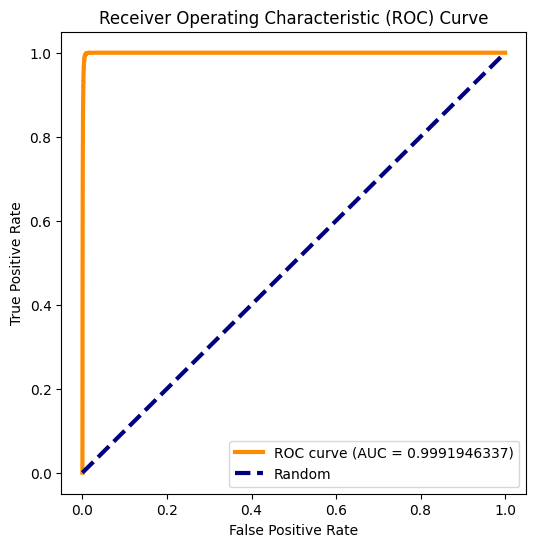

In [449]:
# ROC görbe számítása
fpr, tpr, treshold = roc_curve(originals, predictions, pos_label=1)
roc_auc = auc(fpr, tpr)

# ROC görbe ábrázolása
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.10f})')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('ROC_curve.png')
plt.show()

In [450]:
## Classifier using Linear Regression on Planetoid dataset

In [451]:
# DATAFRAME
X = embeddings
y = dataset.y
columns_X = [f'feature_{i}' for i in range(X.shape[1])]
df_X = pd.DataFrame(X, columns=columns_X)

# Add the 'y' column to the DataFrame
df_X['class'] = y

# Display the DataFrame
df_X.head(5)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,class
0,0.002451,-0.133350,0.196334,-0.137766,0.634519,-0.043814,0.238726,-0.312338,-0.100691,-0.181093,...,0.087196,0.367205,0.574388,-0.351764,0.041941,-0.339525,0.190347,-0.122429,0.109597,3
1,-0.015723,0.010311,-0.029710,-0.113817,0.022891,-0.116883,0.107008,-0.439297,-0.074728,-0.094548,...,0.114182,0.054549,-0.457513,0.251935,0.001454,-0.272283,0.352526,-0.226937,0.246260,4
2,0.117382,0.050534,-0.086215,-0.111601,0.101939,-0.103655,0.044153,-0.156214,-0.114464,-0.102738,...,0.075183,-0.018317,-0.279305,0.112341,-0.114243,-0.382256,0.410405,-0.011220,0.394783,4
3,0.021139,0.381777,-0.142824,0.090030,0.165219,-0.054544,0.086711,-0.052165,0.249992,-0.376121,...,-0.322036,0.095034,-0.056119,0.057059,0.262114,-0.270448,-0.358133,0.012021,0.053739,0
4,0.310099,0.121952,0.041187,0.143730,-0.186473,-0.199419,0.107551,-0.225350,0.184453,0.075379,...,0.124176,-0.429747,-0.142490,-0.023794,0.107764,-0.144235,0.337199,0.342808,-0.001510,3


In [452]:
df_X['class'].value_counts()

3    818
4    426
2    418
0    351
5    298
1    217
6    180
Name: class, dtype: int64

In [453]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

X = df_X.drop('class', axis=1)
y = df_X['class']

df_columns = X.columns
scaler = StandardScaler()
df = scaler.fit_transform(X)
X = pd.DataFrame(df)
X.columns = df_columns

# Create a linear regression model
model = LinearRegression()

# Specify the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cross_val_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')  # You can use other scoring metrics

# Display the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Mean R^2:", np.mean(cross_val_scores))

Cross-Validation Scores: [0.48841013 0.48259272 0.50978263 0.41313458 0.47722104]
Mean R^2: 0.474228222604829


In [454]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute F1 score (micro and macro)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Display the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nF1 Score (Micro):", f1_micro)
print("F1 Score (Macro):", f1_macro)
print("Accuracy:", accuracy)


Confusion Matrix:
[[ 58   1   1   9   2   2   2]
 [  2  36   3   2   2   0   1]
 [  3   2  69   3   1   1   1]
 [ 14   5   3 149   9   6   5]
 [  4   1   1   6  61   2   1]
 [  3   0   3   6   0  26   6]
 [  2   0   0   4   0   3  21]]

F1 Score (Micro): 0.7749077490774909
F1 Score (Macro): 0.747638771654442
Accuracy: 0.7749077490774908


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [455]:
with open("results.txt", "w") as file:
  file.write("Parameters:\n")

  file.write(f"P= {p}\n")
  file.write(f"Q= {q}\n")
  file.write(f"Embedding Dimension= {embedding_dim}\n")
  file.write(f"Walk Length= {walk_length}\n")
  file.write(f"Context Size= {context_size}\n")
  file.write(f"Walks Per Node= {walks_per_node}\n")
  file.write(f"Learning Rate= {lr}\n")
  file.write(f"Batch Size= {batch_size}\n")
  file.write("\n")
  file.write("Results:\n")
  file.write("\n")
  file.write("Link Prediction:\n")
  file.write(f"ROC-AUC score= {roc_auc}\n")
  file.write("\n")
  file.write("Node Classification with Logistic Regression:\n")
  file.write(f"F1 Score (Micro)= {f1_micro}\n")
  file.write(f"F1 Score (Macro)= {f1_macro}\n")
  file.write(f"Accuracy= {accuracy}\n")

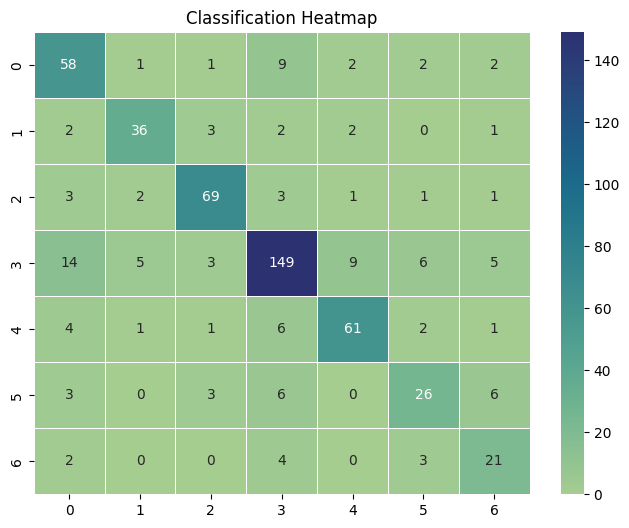

In [456]:
import seaborn as sn
df_cm = pd.DataFrame(conf_matrix, index = [i for i in range(len(conf_matrix[0]))],
                  columns = [i for i in range(len(conf_matrix[0]))])

plt.figure(figsize = (8,6))
plt.title("Classification Heatmap")
sn.heatmap(df_cm, annot=True,fmt=".0f",linewidth=.5, cmap="crest")
plt.savefig("heatmap.png")
plt.show()